# Gaussian processes demonstration

Last revised: 04-Oct-2020 by Christian Forssén [christian.forssen@chalmers.se]

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import GPy

# Not really needed, but nicer plots
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

## Gaussian processes as infinite-dimensional Gaussian distributions
Adapted partly from a tutorial by [Andreas Damianou](http://adamian.github.io/talks/Brown2016.html) (2016).

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.

### Intuition by sampling and plotting multivariate Gaussians

Let's first define some plotting functions that we'll use later. 

In [2]:
def gen_Gaussian_samples(mu, sigma, N=200):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    """
    D = mu.shape[0]
    samples = np.zeros((N,D))
    for i in np.arange(N):
        samples[i,:] = np.random.multivariate_normal(mean=mu, cov=sigma)
    return samples.copy()


def gen_plot_Gaussian_samples(mu, sigma,N=1000):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    and plot the samples as they're generated
    """
    for i in np.arange(N):
        sample = np.random.multivariate_normal(mean=mu, cov=sigma)
        plt.plot(sample[0],sample[1], '.',color='r',alpha=0.6)


def plot_Gaussian_contours(x,y,mu,sigma,N=100):
    """
    Plot contours of a 2D multivariate Gaussian based on N points. Given points x and y are 
    given for the limits of the contours
    """
    X, Y = np.meshgrid(np.linspace(x.min()-0.3,x.max()+0.3,100), np.linspace(y.min()-0.3,y.max()+0.3,N))
    rv = multivariate_normal(mu, sigma)
    Z = rv.pdf(np.dstack((X,Y)))
    plt.contour(X,Y,Z)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')

def plot_sample_dimensions(samples, colors=None, markers=None, ms=10):
    """
    Given a set of samples from a bivariate Gaussian, plot them, but instead of plotting them
    x1 vs x2, plot them as [x1 x2] vs ['1', '2']
    """
    N = samples.shape[0]
    D = samples.shape[1]
    
    t=np.array(range(1,D+1))

    for i in np.arange(N):
        if colors is None and markers is None:
            plt.plot(t,samples[i,:], '-o',ms=ms)
        elif colors is None:
            plt.plot(t,samples[i,:], '-o',marker=markers[i],ms=ms)
        elif markers is None:
            plt.plot(t,samples[i,:], '-o',color=colors[i],ms=ms)
        else:
            plt.plot(t,samples[i,:], '-o',color=colors[i],marker=markers[i],ms=ms)
    plt.xlim([0.8,t[-1]+0.2])
    plt.ylim([samples.min()-0.3, samples.max()+0.3])
    plt.xlabel('d = {' + str(t) + '}')
    plt.ylabel(r'$x_d$')
    plt.gca().set_title(str(N) + ' samples from a bivariate Gaussian')


def set_limits(samples):
    plt.xlim([samples[:,0].min()-0.3, samples[:,0].max()+0.3])
    plt.ylim([samples[:,1].min()-0.3, samples[:,1].max()+0.3])

Test two different ways of plotting a bivariate Gaussian.

 /Applications/anaconda3/envs/tif285-dev-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
 /Applications/anaconda3/envs/tif285-dev-env/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
 /Applications/anaconda3/envs/tif285-dev-env/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
 /Applications/anaconda3/envs/tif285-dev-env/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword 

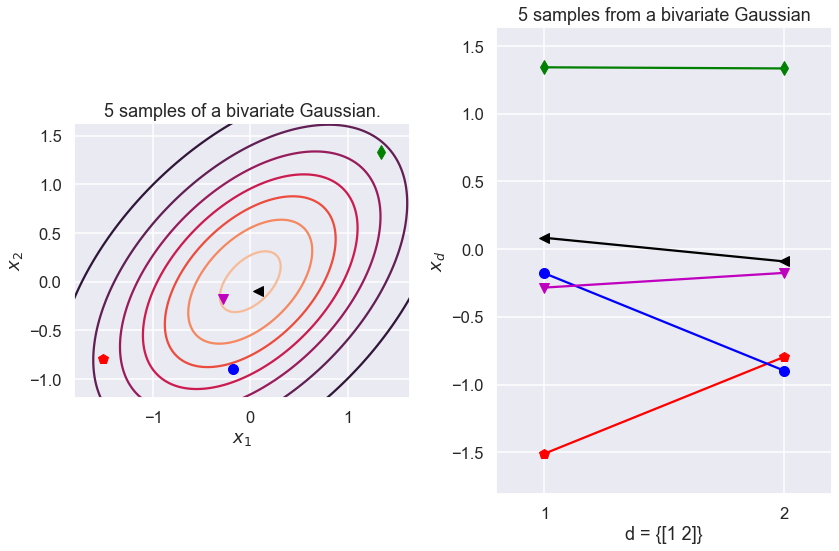

In [3]:
colors = ['r','g','b','m','k']
markers = ['p','d','o','v','<']

N=5 # Number of samples
mu = np.array([0,0])  # Mean of the 2D Gaussian
sigma = np.array([[1, 0.5], [0.5, 1]]); # covariance of the Gaussian

# Generate samples
np.random.seed(10)
samples = gen_Gaussian_samples(mu,sigma,N) 

f=plt.figure(figsize=(12,8)); 
ax1=plt.subplot(1, 2, 1,autoscale_on=True, aspect='equal')
#set_limits(samples)
plot_Gaussian_contours(samples[:,0],samples[:,1],mu,sigma)

# Plot samples
for i in np.arange(N):
    plt.plot(samples[i,0],samples[i,1], 'o', color=colors[i], marker=markers[i],ms=10)
plt.gca().set_title(f'{N} samples of a bivariate Gaussian.')

ax2=plt.subplot(1, 2, 2,autoscale_on=True)#, aspect='equal')
ax2.set_xticks([1,2])
plot_sample_dimensions(samples=samples, colors=colors, markers=markers)

plt.tight_layout()

Repeat as before, but now we'll plot many samples from two kinds of Gaussians: one which with strongly correlated dimensions and one with weak correlations

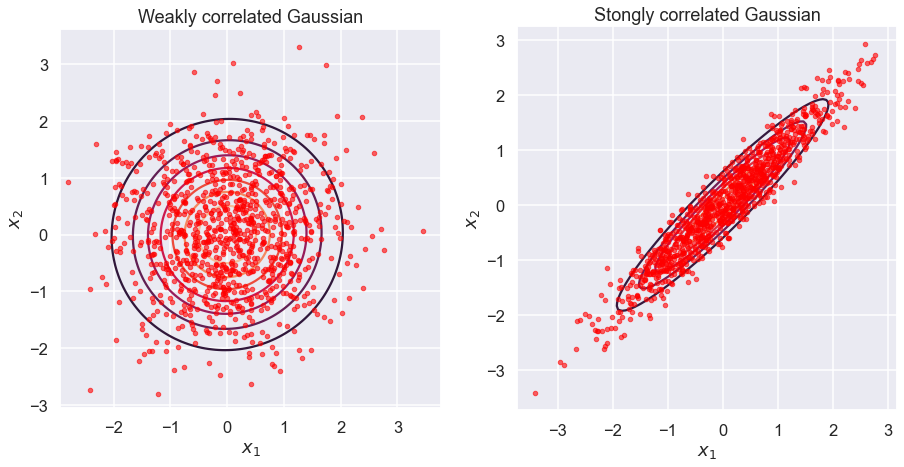

In [4]:
# Plot with contours. Compare a correlated vs almost uncorrelated Gaussian

sigmaUncor = np.array([[1, 0.02], [0.02, 1]]);
sigmaCor = np.array([[1, 0.95], [0.95, 1]]);

f=plt.figure(figsize=(15,15)); 

ax=plt.subplot(1, 2, 1); ax.set_aspect('equal')
samplesUncor=gen_Gaussian_samples(mu,sigmaUncor)
plot_Gaussian_contours(samplesUncor[:,0],samplesUncor[:,1], mu, sigmaUncor)
gen_plot_Gaussian_samples(mu, sigmaUncor)
ax.set_title('Weakly correlated Gaussian')

ax=plt.subplot(1, 2, 2); ax.set_aspect('equal')
samplesCor=gen_Gaussian_samples(mu,sigmaCor)
plot_Gaussian_contours(samplesCor[:,0],samplesCor[:,1], mu, sigmaCor)
gen_plot_Gaussian_samples(mu, sigmaCor)
ax.set_title('Stongly correlated Gaussian');

But let's plot them as before dimension-wise...

> Which one is which?

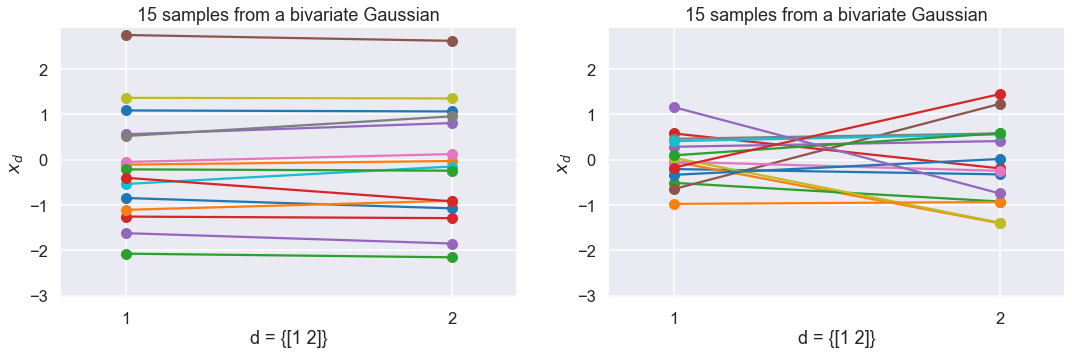

In [5]:
f=plt.figure(figsize=(18,5)); 
perm = np.random.permutation(samplesUncor.shape[0])[0::14]

ax1=plt.subplot(1, 2, 2); ax1.set_aspect('auto')
plot_sample_dimensions(samplesUncor[perm,:])
ax2=plt.subplot(1, 2, 1,sharey=ax1); ax2.set_aspect('auto')
plot_sample_dimensions(samplesCor[perm,:])
if False:
    ax1.set_title('Weakly correlated');
    ax2.set_title('Strongly correlated')
for ax in [ax1,ax2]:
    ax.set_xticks([1,2])
plt.ylim([samplesUncor.min()-0.3, samplesUncor.max()+0.3]);

* The strongly correlated Gaussian gives more "horizontal" lines in the dimension-wise plot.

* More importantly, by using the dimension-wise plot, we are able to plot Gaussians which have more than two dimensions. Below we plot N samples from a D=8-dimensional Gaussian. 

* Because I don't want to write down the full 8x8 covariance matrix, I define a "random" one through a mathematical procedure that is guaranteed to give me back a positive definite and symmetric matrix (i.e. a valid covariance). More on this later.

Covariance matrix:
[[ 5.04  5.06  5.11  5.16  5.17  5.21  5.3   5.39]
 [ 5.06  5.1   5.17  5.24  5.26  5.32  5.47  5.61]
 [ 5.11  5.17  5.33  5.47  5.51  5.61  5.93  6.26]
 [ 5.16  5.24  5.47  5.69  5.75  5.91  6.42  6.98]
 [ 5.17  5.26  5.51  5.75  5.82  6.    6.57  7.2 ]
 [ 5.21  5.32  5.61  5.91  6.    6.24  6.98  7.83]
 [ 5.3   5.47  5.93  6.42  6.57  6.98  8.38 10.12]
 [ 5.39  5.61  6.26  6.98  7.2   7.83 10.12 13.21]]
Eigenvalues all larger than zero
[49.62  4.94  0.22  0.01  0.01  0.    0.01  0.01]


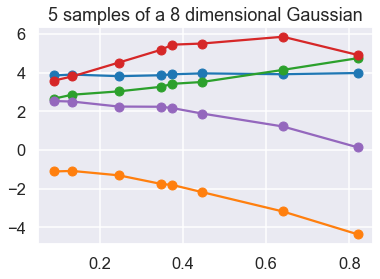

In [6]:
N=5
mu = np.array([0,0,0,0,0,0,0,0])
D = mu.shape[0]

# Generate random covariance matrix
tmp = np.sort(sp.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T) + 0.005*np.eye(D)
with np.printoptions(precision=2, suppress=True):
    print('Covariance matrix:')
    print(sigma)
    print('Eigenvalues all larger than zero')
    print(np.linalg.eigvals(sigma))

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-o')

plt.gca().set_title(f'{N} samples of a {D} dimensional Gaussian');

Taking this even further, we can plot samples from a 200-dimensional Gaussian in the dimension-wise plot. 

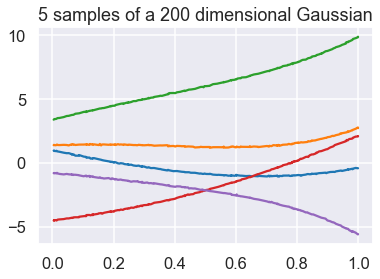

In [7]:
N=5
D=200
mu = np.zeros((D,1))[:,0]

# Generate random covariance matrix
tmp = np.sort(sp.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T)+ 0.0005*np.eye(D)

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-')

plt.gca().set_title(f'{N} samples of a {D} dimensional Gaussian');

We see that each sample now starts looking like a "smooth" curve (notice that the random variables are highly correlated). Therefore, we now have a clear intuition as to why a GP can be seen as an *infinite dimensional multivariate Gaussian* which is used as a *prior over functions*, since one sample from a GP is a function.

### Mean and covariance function

Similarly to how a D-dimensional Gaussian is parameterized by its mean vector and its covariance matrix, a GP is parameterized by a mean *function* and a covariance *function*. To explain this, we'll assume (without loss of generality) that the mean function is $\mu(x) = \mathbf{0}$. As for the covariance function, $C(x,x')$, it is a function that receives as input two locations $x,x'$ belonging to the input domain, i.e. $x,x' \in \mathcal{X}$, and returns the value of their co-variance.

In this way, if we have a *finite* set of input locations we can evaluate the covariance function at every pair of locations and obtain a covariance matrix $\mathbf{C}$. We write:
$$
\mathbf{C} = C(\mathbf{X}, \mathbf{X}),
$$
where $\mathbf{X}$ is the collection of training inputs.

More on covariance functions later. For the moment, think of them as kind of a black box.

### Covariance functions, aka kernels

We saw above their role for creating covariance matrices from training inputs, thereby allowing us to work with a finite domain when it is potentially infinite.

We'll see below that the covariance function is what encodes our assumption about the GP. By selecting a covariance function, we are making implicit assumptions about the shape of the function we wish to encode with the GP, for example how smooth it is.

Even if the covariance function has a parametric form, combined with the GP it gives us a nonparametric model. In other words, the covariance function is specifying the general properties of the GP function we wish to encode, and not a specific parametric form for it.

Below we define two very common covariance functions: The RBF (also known as Exponentiated Quadratic or Gaussian kernel) which is differentiable infinitely many times (hence, very smooth),
$$
k_{RBF}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \sum_{q=1}^Q (x_{i,q} - x_{j,q})^2\right)
$$
where $Q$ denotes the dimensionality of the input space. Its parameters are: the *lengthscale*, $\ell$ and the variance $\sigma^2$. Furthermore, the linear kernel:
$$
k_{lin}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma^2 \mathbf{x}_{i}^T \mathbf{x}_{j}
$$

Below, we will implement and investigate them.

#### The RBF kernel (a.k.a Gaussian)

In [8]:
def cov_RBF(x, x2=None, alpha=np.array([1,1])):        
        """
        Compute the Euclidean distance between each row of X and X2, or between
        each pair of rows of X if X2 is None and feed it to the kernel.
        """
        variance = alpha[0]
        lengthscale = alpha[1]
        if x2 is None:
            xsq = np.sum(np.square(x),1)
            r2 = -2.*np.dot(x,x.T) + (xsq[:,None] + xsq[None,:])
            r = np.sqrt(r2)/lengthscale
        else:
            x1sq = np.sum(np.square(x),1)
            x2sq = np.sum(np.square(x2),1)
            r2 = -2.*np.dot(x, x2.T) + x1sq[:,None] + x2sq[None,:]
            r = np.sqrt(r2)/lengthscale

        return variance * np.exp(-0.5 * r**2)

Given hyperparameters $\theta$, we plot the resulting covariance matrix and samples from a GP with this covariance function.

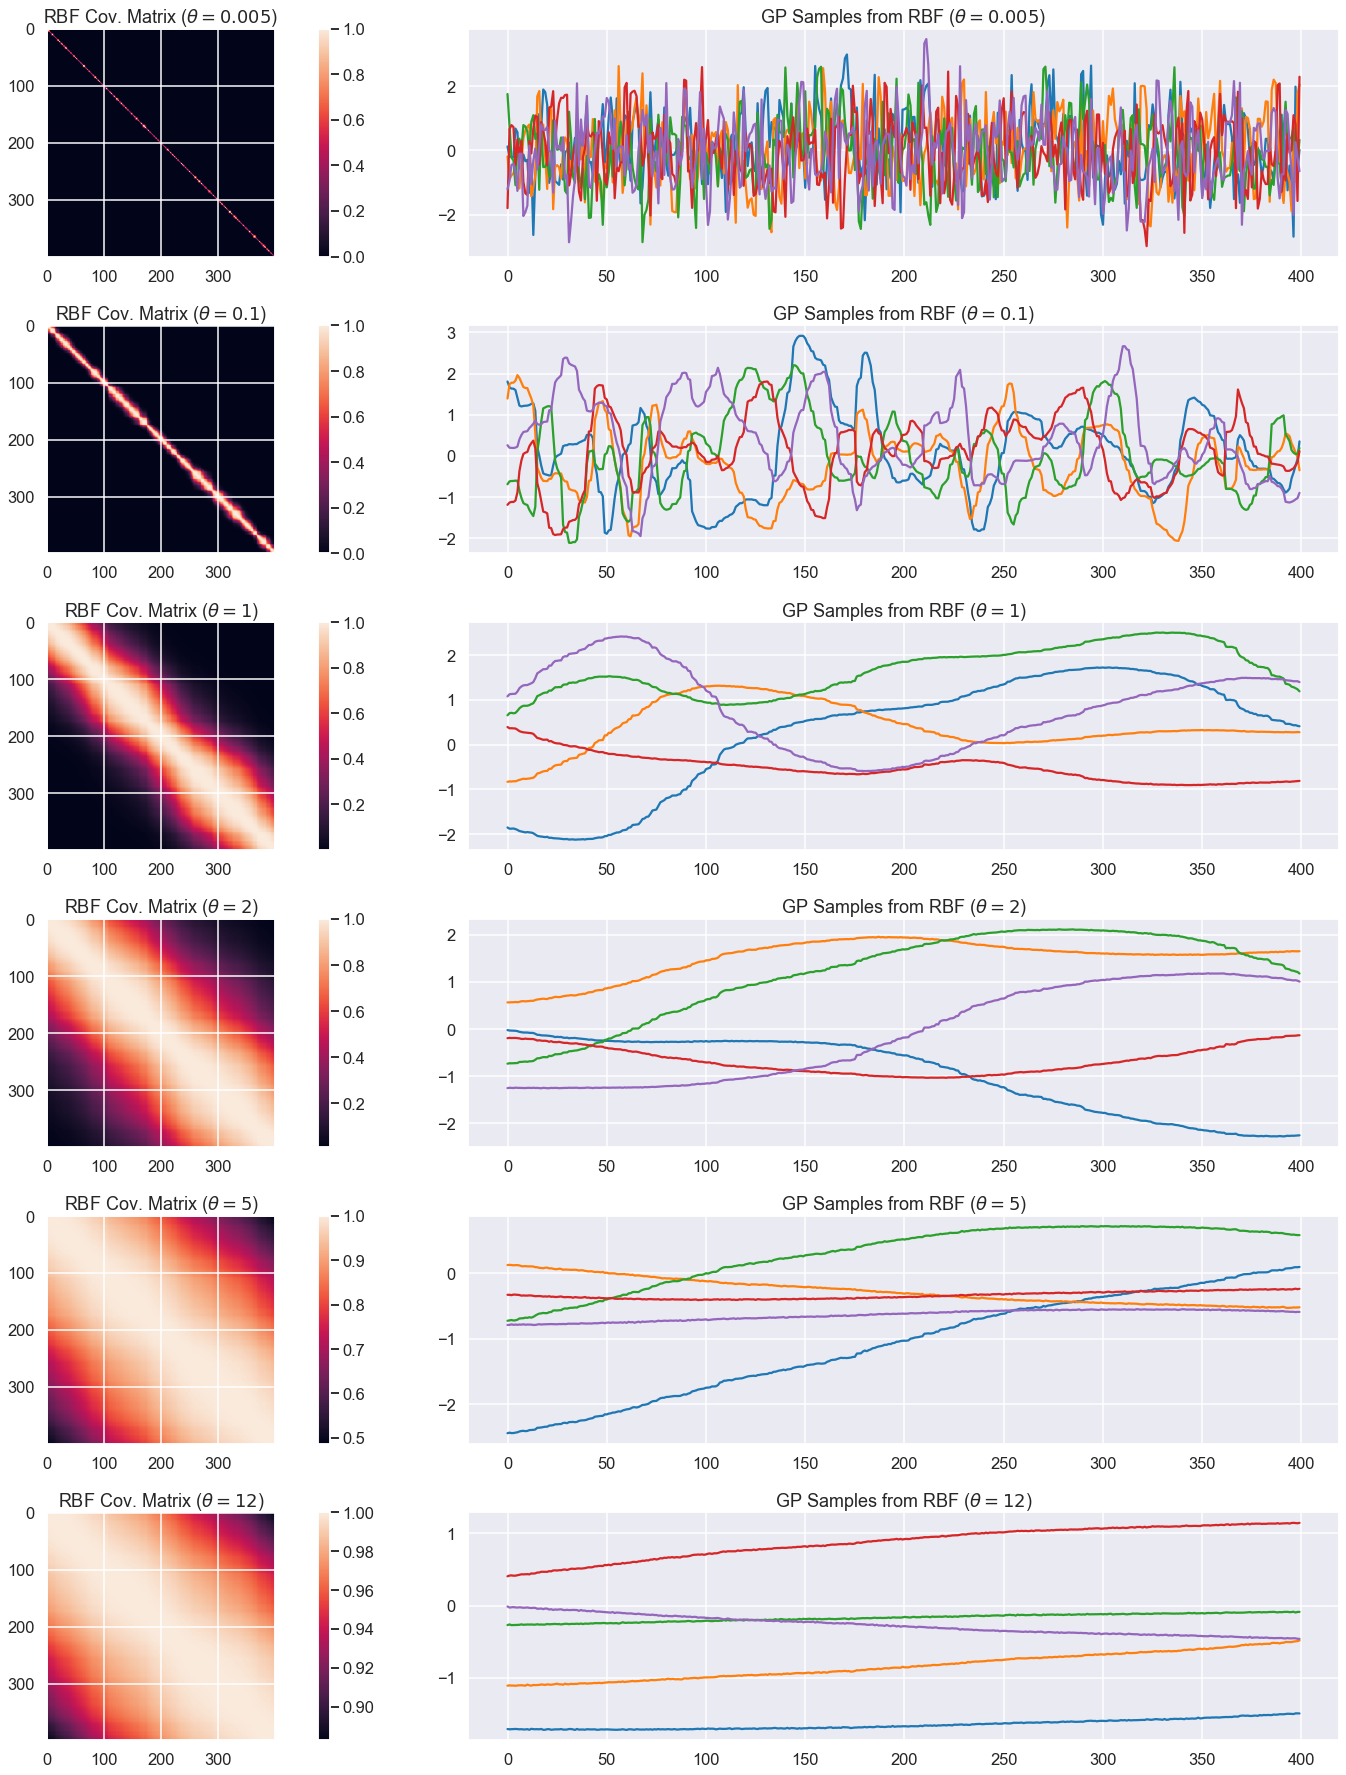

In [9]:
X = np.sort(np.random.rand(400, 1) * 6 , axis=0)

params_rbf    = [0.005, 0.1, 1, 2, 5, 12]
K = len(params_rbf)

num_samples=5
plt.figure(figsize=(25,25))
j=1
for i in range(K):
    plt.subplot(K,2,j)
    K_rbf = cov_RBF(X,X,alpha=np.array([1,params_rbf[i]]))
    plt.imshow(K_rbf)
    plt.colorbar()
    plt.gca().set_title(rf'RBF Cov. Matrix ($\theta={params_rbf[i]}$)')
    
    plt.subplot(K,2,j+1)
    # Assume a GP with zero mean
    mu=np.zeros((1,K_rbf.shape[0]))[0,:]
    for s in range(num_samples):
        # Jitter is a small noise addition to the diagonal elements to ensure positive definiteness
        jitter = 1e-5*np.eye(K_rbf.shape[0])
        sample = np.random.multivariate_normal(mean=mu, cov=K_rbf+jitter)
        plt.plot(sample)
    plt.gca().set_title(rf'GP Samples from RBF ($\theta={params_rbf[i]}$)')
    j+=2
    
plt.tight_layout()

## Example: GP models for regression
### No-core shell model $\hbar\omega$ dependence

In [10]:
# import some NCSM data from
# Phys. Rev. C 97, 034328 (2018)
(E,Nmax,hw)=np.loadtxt('data/Li6E_NNLOopt_Nmax10.txt',unpack=True)

OSError: data/Li6E_NNLOopt_Nmax10.txt not found.

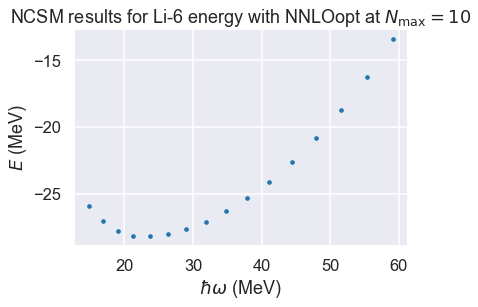

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_ylabel(r'$E$ (MeV)');
ax.set_xlabel(r'$\hbar\omega$ (MeV)');
ax.set_title(r'NCSM results for Li-6 energy with NNLOopt at $N_\mathrm{max}=10$')
ax.scatter(hw,E,s=10);

GP_regression.,value,constraints,priors
rbf.variance,2.7334831243366655,+ve,
rbf.lengthscale,15.493754387168465,+ve,
Gaussian_noise.variance,3.9116924072201616e-10,+ve,


Validation result: Ratio true/predict in [0.998527,1.004752]


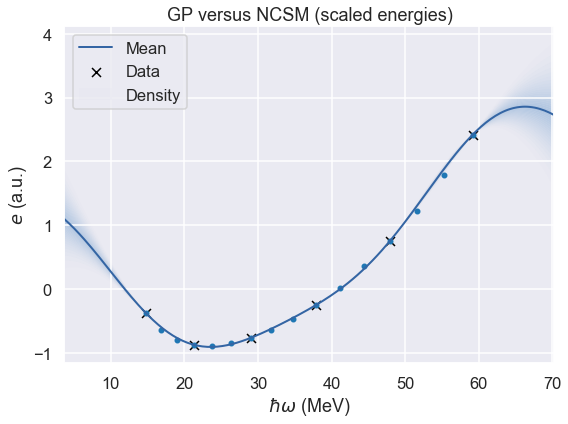

In [13]:
# We will test our GP by training on every third data point and validate on the rest.
# We will print the largest ratios (predict-true)/predict for the interpolate region.
ratio_min=1.
ratio_max=1.

x=hw
mE = np.mean(E)
sE = np.std(E)
y= (E - mE)/sE
xt = x[::3, np.newaxis]
yt = y[::3, np.newaxis]

kernel = GPy.kern.RBF(input_dim=1, variance=5., lengthscale=10.)
m = GPy.models.GPRegression(xt,yt,kernel)
m.optimize(messages=False)
display(m)
xp = x[:, np.newaxis]
yp,vp=m.predict(xp)
for i,yi in enumerate(yp):
    ratio_min=min(ratio_min,np.abs((y[i]+mE)/(yi+mE)))
    ratio_max=max(ratio_max,np.abs((y[i]+mE)/(yi+mE)))
fig = m.plot(plot_density=True,figsize=(8,6))
ax=plt.gca()
ax.scatter(hw,(E-mE)/sE,s=20);
ax.set(xlabel=r'$\hbar\omega$ (MeV)',ylabel=r'${e}$ (a.u.)')
ax.set_title(r'GP versus NCSM (scaled energies)')
print('Validation result: Ratio true/predict in [%8.6f,%8.6f]' %(ratio_min,ratio_max))